In [1]:
import pyclesperanto_prototype as cle
from skimage.io import imread
import numpy as np
import scipy.ndimage as ndi
import napari

In [2]:
cle.select_device("cpu")

<Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz on Platform: Apple (2 refs)>

In [3]:
slice = imread("/Users/rossg/Documents/clij-data/CZI_dCLIJ/Run1_slice_01596_z=8.2037um.tif")
slice.shape
slice = slice[5000:7000, 2000: 10000]

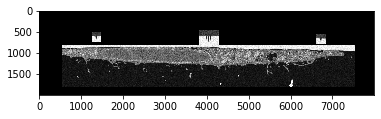

In [4]:
cle.imshow(slice)

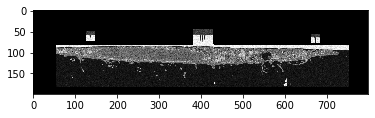

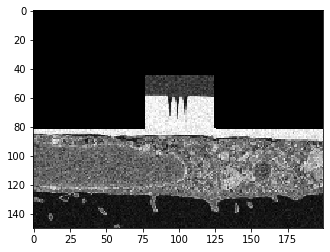

In [5]:
slice_downsample = cle.scale(slice, factor_x=0.1, factor_y=0.1, auto_size=True)
cle.imshow(slice_downsample)

template_downsample = slice_downsample[0:150, 305:505]
cle.imshow(template_downsample)

In [6]:
ccorr = cle.cross_correlation(slice_downsample, template_downsample)

    200 150
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

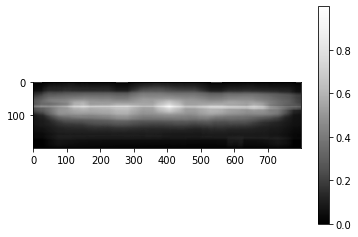

In [7]:
cle.imshow(ccorr, colorbar=True)

In [8]:
ccorr.min(), ccorr.max()

(nan, nan)

In [9]:
# # global_max = np.argmax(ccorr)
# global_max = ndi.maximum_position(ccorr)
# print(global_max)

In [10]:
viewer = napari.Viewer()
viewer.add_image(ccorr)
viewer.add_image(slice_downsample)

/usr/local/anaconda3/envs/cle_39/lib/python3.9/site-packages/napari/_qt/__init__.py:53: UserWarning: 

napari was tested with QT library `>=5.12.3`.
The version installed is 5.9.7. Please report any issues with
this specific QT version at https://github.com/Napari/napari/issues.
  warn(message=warn_message)


<Image layer 'slice_downsample' at 0x7fd8303bc2e0>

$$norm\_corr(x,y)=\dfrac{\sum_{n=0}^{n-1} x[n]*y[n]}{\sqrt{\sum_{n=0}^{n-1} x[n]^2 * \sum_{n=0}^{n-1} y[n]^2}}$$

$$\begin{align}
norm\_corr(a,b) &= \dfrac{1*2+2*3+-2*-2+4*3+2*2+3*4+1*1+0*-1}{\sqrt{(1+4+4+16+4+9+1+0)*(4+9+4+9+4+16+1+1)}} \\
& = \dfrac{41}{\sqrt{(39)*(48)}} \\
& = 0.947
\end{align}$$

$$\begin{align}
norm\_corr(a,c) & =\dfrac{1*-2+2*0+-2*4+4*0+2*1+3*1+1*0+0*-2}{\sqrt{(1+4+4+16+4+9+1+0)*(4+0+16+0+1+1+0+4)}} \\
& =\dfrac{-5}{\sqrt{(39)*(26)}} \\
& =-0.157
\end{align}$$